# Dependencies

In [1]:
pacman::p_load(factoextra, dplyr)

# Functions

# Paths

In [2]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

# PBMC

In [3]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [4]:
meta_div <- meta_div[ !is.na(meta_div$TRB), ]

In [5]:
meta_div <- meta_div[ meta_div$sampletype == "PBMC",]

In [6]:
head(meta_div)

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
287,CHP_10YO_M_00,CHP_10YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,10.601,0.073,8.556,8.561,0.094,CHP_10YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_10YO-M_PBMC_DNA.txt,PBMC,CHP,1.0249370
288,CHP_11YO_M_00,CHP_11YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,11.614,0.054,10.406,10.414,0.066,CHP_11YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_11YO-M_PBMC_DNA.txt,PBMC,CHP,1.0647200
289,CHP_15YO_F_A_00,CHP_15YO_F_A,X00,NA,NA,NA,Normal,NA,NA,NA,...,8.989,0.036,8.560,8.570,0.060,CHP_15YO-F-A_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-A_PBMC_DNA.txt,PBMC,CHP,0.9533731
290,CHP_15YO_F_B_00,CHP_15YO_F_B,X00,NA,NA,NA,Normal,NA,NA,NA,...,6.334,0.040,5.870,5.876,0.066,CHP_15YO-F-B_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-B_PBMC_DNA.txt,PBMC,CHP,0.8014037
291,CHP_15YO_M_00,CHP_15YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,21.120,0.040,20.321,20.339,0.068,CHP_15YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-M_PBMC_DNA.txt,PBMC,CHP,1.3244882
292,CHP_16YO_M_00,CHP_16YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,3.973,0.007,3.944,3.946,0.013,CHP_16YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_16YO-M_PBMC_DNA.txt,PBMC,CHP,0.5990092


In [7]:
flelist <- file.path(paste0( h4hpath, "/NextSeq/", meta_div$file) )

In [8]:
head(flelist)

[1] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_10YO-M_PBMC_DNA.txt"  
[2] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_11YO-M_PBMC_DNA.txt"  
[3] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-A_PBMC_DNA.txt"
[4] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-B_PBMC_DNA.txt"
[5] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-M_PBMC_DNA.txt"  
[6] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_16YO-M_PBMC_DNA.txt"

In [9]:
Vgene.fx <- function(fle){
    onefle <- read.table(fle, header = T, sep = "\t")
    basename <- gsub(".txt", "", basename(fle))
basename <- gsub("CLONES_TRB", "", basename)
onefle$basename <- basename
# Remove non-productive
onefle <- onefle[!grepl("_", onefle$aaSeqCDR3), ]
onefle <- onefle[!grepl("[*]", onefle$aaSeqCDR3), ]

 # if the file has no productive cdr3, message and exit
 if(nrow(onefle) == 0) { next }

# remove scores and take the first hit
onefle$TRBV <- gsub("[*]0.*", "", onefle$allVHitsWithScore)
onefle$TRBJ <- gsub("[*]0.*", "", onefle$allJHitsWithScore)
# remove super long cdr3s
onefle <- onefle[nchar(onefle$aaSeqCDR3) <= 25, ]

 #exit if the file has no productive cdr3
 if(nrow(onefle) == 0) { next }

onefle$cdr3_length <- nchar(onefle$aaSeqCDR3)
onefle_s <- onefle[, c("basename", "aaSeqCDR3", "cdr3_length", "TRBV", "TRBJ", "cloneCount", "cloneFraction")]

return(onefle_s)
}

In [23]:
myflelist <- lapply(flelist, Vgene.fx)

In [24]:
int_v_j_cdr3_l <- do.call("rbind", myflelist)

In [25]:
head(int_v_j_cdr3_l)

,basename,aaSeqCDR3,cdr3_length,TRBV,TRBJ,cloneCount,cloneFraction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
1,CHP_10YO-M_PBMC_DNA,CASSQYTADTQYF,13,TRBV13,TRBJ2-3,3012,0.20644277
2,CHP_10YO-M_PBMC_DNA,CASSDGRYGRDSNTEAFF,18,TRBV2,TRBJ1-1,1590,0.10897875
3,CHP_10YO-M_PBMC_DNA,CASSLNSGGTYGYTF,15,TRBV12-4,TRBJ1-2,1301,0.08917066
4,CHP_10YO-M_PBMC_DNA,CASYEGEWNTEAFF,14,TRBV2,TRBJ1-1,1214,0.08320768
6,CHP_10YO-M_PBMC_DNA,CASSLGPNTEAFF,13,TRBV12-4,TRBJ1-1,1088,0.07457162
7,CHP_10YO-M_PBMC_DNA,CASSNGSGRPEAFF,14,TRBV19,TRBJ1-1,860,0.05894448


In [26]:
readr::write_rds(int_v_j_cdr3_l, paste0(datapath, "capTCRseq/int_pbmc_v_j_cdr3_l.rds"))

In [27]:
int_v_j_cdr3_l <- readr::read_rds( paste0(datapath, "capTCRseq/int_pbmc_v_j_cdr3_l.rds"))

In [28]:
head(int_v_j_cdr3_l)

,basename,aaSeqCDR3,cdr3_length,TRBV,TRBJ,cloneCount,cloneFraction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
1,CHP_10YO-M_PBMC_DNA,CASSQYTADTQYF,13,TRBV13,TRBJ2-3,3012,0.20644277
2,CHP_10YO-M_PBMC_DNA,CASSDGRYGRDSNTEAFF,18,TRBV2,TRBJ1-1,1590,0.10897875
3,CHP_10YO-M_PBMC_DNA,CASSLNSGGTYGYTF,15,TRBV12-4,TRBJ1-2,1301,0.08917066
4,CHP_10YO-M_PBMC_DNA,CASYEGEWNTEAFF,14,TRBV2,TRBJ1-1,1214,0.08320768
6,CHP_10YO-M_PBMC_DNA,CASSLGPNTEAFF,13,TRBV12-4,TRBJ1-1,1088,0.07457162
7,CHP_10YO-M_PBMC_DNA,CASSNGSGRPEAFF,14,TRBV19,TRBJ1-1,860,0.05894448


In [46]:
int_v_j_cdr3_l[ int_v_j_cdr3_l$basename == "LFS_TCR-5067-PBMC-DNA" &
int_v_j_cdr3_l$TRBV == "TRBV7-2",]

,basename,aaSeqCDR3,cdr3_length,TRBV,TRBJ,cloneCount,cloneFraction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
108135,LFS_TCR-5067-PBMC-DNA,CASSPGGGNTIYF,13,TRBV7-2,TRBJ1-3,6,0.0034662045
135115,LFS_TCR-5067-PBMC-DNA,CASSPTSGGTPYNEQFF,17,TRBV7-2,TRBJ2-1,4,0.0023108030
24078,LFS_TCR-5067-PBMC-DNA,CASSPFGTVENEQYF,15,TRBV7-2,TRBJ2-7,1,0.0005777008
25377,LFS_TCR-5067-PBMC-DNA,CASSVPNQPQHF,12,TRBV7-2,TRBJ1-5,1,0.0005777008


In [48]:
int_v <- int_v_j_cdr3_l %>% group_by(basename, TRBV) %>% summarize(Vcount = sum(cloneCount)) %>% ungroup()

`summarise()` has grouped output by 'basename'. You can override using the
`.groups` argument.


In [49]:
head(int_v)

basename,TRBV,Vcount
<chr>,<chr>,<int>
CHP-328-04-PBMC-DNA,TRBV10-1,14581
CHP-328-04-PBMC-DNA,TRBV10-2,2306
CHP-328-04-PBMC-DNA,TRBV10-3,405
CHP-328-04-PBMC-DNA,TRBV11-1,1123
CHP-328-04-PBMC-DNA,TRBV11-2,3818
CHP-328-04-PBMC-DNA,TRBV11-3,1897


In [50]:
int_v_count <- tidyr::pivot_wider(int_v, names_from = "TRBV", values_from = "Vcount", values_fill = 0)

In [51]:
head(int_v_count)

basename,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-2,TRBV12-3,TRBV12-4,...,TRBV7-4,TRBV1,TRBV12-1,TRBV6-7,TRBV7-1,TRBV6-9,TRBV5-2,TRBV6-8,TRBV7-5,TRBV26
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CHP-328-04-PBMC-DNA,14581,2306,405,1123,3818,1897,119,2627,10206,...,0,0,0,0,0,0,0,0,0,0
CHP-328-05-PBMC-DNA,119,130,29,0,196,79,0,1626,825,...,15,0,0,0,0,0,0,0,0,0
CHP-351-03-PBMC-DNA,669,401,12834,780,2637,591,637,3120,2932,...,19,31,91,372,0,0,0,0,0,0
CHP-369-01-PBMC-DNA,1315,3593,17363,1147,3712,502,0,9747,13006,...,0,0,0,1229,27,0,0,0,0,0
CHP-377-02-PBMC-DNA,392,222,376,223,458,366,0,1704,1594,...,0,0,0,78,0,0,0,0,0,0
CHP-411-02-PBMC-DNA,911,1069,2795,1039,2155,658,0,3771,3825,...,160,45,0,0,0,0,0,0,0,0


In [52]:
int_v_count <- as.data.frame(int_v_count)
rownames(int_v_count) <- int_v_count$basename
int_v_count$basename <- NULL

In [53]:
head(int_v_count)

,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-2,TRBV12-3,TRBV12-4,TRBV12-5,...,TRBV7-4,TRBV1,TRBV12-1,TRBV6-7,TRBV7-1,TRBV6-9,TRBV5-2,TRBV6-8,TRBV7-5,TRBV26
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CHP-328-04-PBMC-DNA,14581,2306,405,1123,3818,1897,119,2627,10206,554,...,0,0,0,0,0,0,0,0,0,0
CHP-328-05-PBMC-DNA,119,130,29,0,196,79,0,1626,825,255,...,15,0,0,0,0,0,0,0,0,0
CHP-351-03-PBMC-DNA,669,401,12834,780,2637,591,637,3120,2932,1730,...,19,31,91,372,0,0,0,0,0,0
CHP-369-01-PBMC-DNA,1315,3593,17363,1147,3712,502,0,9747,13006,812,...,0,0,0,1229,27,0,0,0,0,0
CHP-377-02-PBMC-DNA,392,222,376,223,458,366,0,1704,1594,431,...,0,0,0,78,0,0,0,0,0,0
CHP-411-02-PBMC-DNA,911,1069,2795,1039,2155,658,0,3771,3825,571,...,160,45,0,0,0,0,0,0,0,0


In [54]:
readr::write_rds(int_v_count, paste0(datapath, "capTCRseq/int_pbmc_v_count.rds"))

In [57]:
int_v <- int_v_j_cdr3_l %>% group_by(basename, TRBV) %>% summarize(Vfrac = sum(cloneFraction)) %>% ungroup()

`summarise()` has grouped output by 'basename'. You can override using the
`.groups` argument.


In [58]:
head(int_v)

basename,TRBV,Vfrac
<chr>,<chr>,<dbl>
CHP-328-04-PBMC-DNA,TRBV10-1,0.052511596
CHP-328-04-PBMC-DNA,TRBV10-2,0.008304762
CHP-328-04-PBMC-DNA,TRBV10-3,0.001458555
CHP-328-04-PBMC-DNA,TRBV11-1,0.004044340
CHP-328-04-PBMC-DNA,TRBV11-2,0.013750036
CHP-328-04-PBMC-DNA,TRBV11-3,0.006831802


In [59]:
int_v_fraction <- tidyr::pivot_wider(int_v, names_from = "TRBV", values_from = "Vfrac", values_fill = 0)

In [61]:
int_v_fraction <- as.data.frame(int_v_fraction)
rownames(int_v_fraction) <- int_v_fraction$basename
int_v_fraction$basename <- NULL

In [63]:
readr::write_rds(int_v_fraction, paste0(datapath, "capTCRseq/int_pbmc_v_fraction.rds"))

In [64]:
# should be done for all files
vfreq <- int_v_j_cdr3_l %>% group_by(TRBV) %>% tally() %>% arrange(desc(n)) %>% mutate(freq = n/sum(n))

In [65]:
head(vfreq)

TRBV,n,freq
<chr>,<int>,<dbl>
TRBV20-1,4222,0.08339424
TRBV19,2567,0.05070417
TRBV7-9,2280,0.04503526
TRBV5-1,2259,0.04462046
TRBV28,2199,0.04343532
TRBV6-5,2156,0.04258597


In [66]:
readr::write_rds(vfreq, paste0(datapath, "capTCRseq/vfreq_int_pbmc.rds"))

In [67]:
summary(vfreq$freq)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
1.975e-05 2.509e-03 1.221e-02 1.639e-02 2.315e-02 8.339e-02 

In [68]:
#low frequency V genes
lowfreq_v <- vfreq$TRBV[vfreq$freq < 0.001 ]

In [69]:
lowfreq_v

[1] "TRBV12-2" "TRBV12-1" "TRBV6-7"  "TRBV1"    "TRBV7-4"  "TRBV5-7" 
 [7] "TRBV6-9"  "TRBV7-1"  "TRBV6-8"  "TRBV7-5"  "TRBV5-2"  "TRBV26"

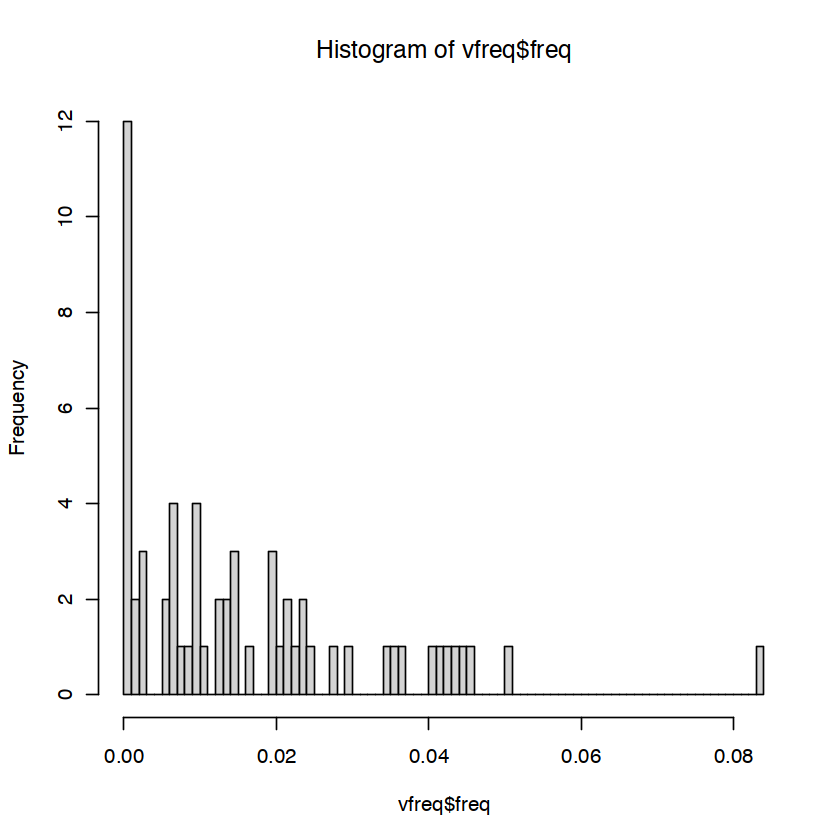

In [70]:
hist(vfreq$freq, breaks = 100)

In [71]:
vgene_mat <- as.data.frame.matrix(table(int_v_j_cdr3_l %>% select(basename, TRBV  )))

In [72]:
head(vgene_mat)

,TRBV1,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-1,TRBV12-2,TRBV12-3,...,TRBV7-1,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-5,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CHP-328-04-PBMC-DNA,0,7,3,4,3,10,2,0,3,13,...,0,14,0,0,0,4,2,8,21,11
CHP-328-05-PBMC-DNA,0,1,2,1,0,3,2,0,0,9,...,0,3,3,1,0,1,0,2,2,6
CHP-351-03-PBMC-DNA,1,4,3,24,8,19,4,1,1,29,...,0,23,21,1,0,18,9,13,52,73
CHP-369-01-PBMC-DNA,0,6,6,18,6,17,2,0,0,21,...,1,8,10,0,0,7,2,2,22,26
CHP-377-02-PBMC-DNA,0,5,1,5,3,12,3,0,0,30,...,0,8,4,0,0,3,0,11,22,21
CHP-411-02-PBMC-DNA,1,6,9,25,14,25,15,0,0,48,...,0,26,15,1,0,11,4,15,60,69


In [73]:
readr::write_rds(vgene_mat, paste0(datapath, "capTCRseq/int_pbmc_vgene_matrix.rds"))

In [74]:
# remove lowfreq_v, hf = high freq
vgene_mat_hf <- vgene_mat[, !colnames(vgene_mat) %in% lowfreq_v ]

In [75]:
dim(vgene_mat_hf)

[1] 221  49

In [76]:
dim(vgene_mat)

[1] 221  61

In [77]:
cormat <- cor(vgene_mat_hf)

In [78]:
#vgene_mat_hf[,c("TRBV10-3", "TRBV7-9", "TRBV13")]

In [79]:
summary(as.vector(cormat) )

# generally high correlation

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08345 0.62324 0.72667 0.69808 0.79891 1.00000 

PCA

In [80]:
mypca <- prcomp(vgene_mat_hf, scale = TRUE)

In [81]:
out <- mypca$x
mydf <- data.frame(out)

In [82]:
head(out)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
CHP-328-04-PBMC-DNA,-5.006471,0.5650993,0.03742088,-2.538840,-0.06424418,-0.215909413,0.001992262,0.84667610,0.7775266,-1.1991008,...,0.21680152,0.009628257,0.22086229,0.246431242,-0.07195632,-0.031484889,-0.250326483,0.34381538,-0.08299217,-0.01813168
CHP-328-05-PBMC-DNA,1.460002,-0.1877939,-0.09194317,-1.304826,-0.46009580,0.426764524,0.110065231,0.23918078,-1.0062285,0.3974634,...,0.03775845,-0.503961614,0.13788616,-0.127186095,-0.12559191,-0.007272142,-0.090793078,0.01991409,0.21516869,-0.07922203
CHP-351-03-PBMC-DNA,-17.989549,2.8557326,0.31020899,1.380491,2.20877826,3.968147946,3.144816198,5.34560123,0.3622490,-2.1909169,...,-0.23501443,0.313240907,0.27547734,0.291348363,0.22911570,0.139931262,0.276120998,0.01403591,-0.02564226,-0.01330318
CHP-369-01-PBMC-DNA,-9.268181,-2.0232455,1.92218571,-1.915525,-0.29847252,-0.009104692,0.634428711,0.06045066,2.8910747,-0.9757597,...,0.34419968,-0.409504425,-0.09937998,0.000915571,0.10166432,0.059653506,-0.008308396,-0.30944222,-0.12912352,0.10777990
CHP-377-02-PBMC-DNA,-5.925406,0.9281065,1.30686447,-1.072786,1.35996077,0.272756431,-0.070248908,-1.33602037,-2.1383691,0.3717638,...,-0.46564285,-0.201698922,-0.23750959,-0.131325843,-0.10335981,-0.169157565,0.046999368,0.01305572,-0.12013920,-0.16745050
CHP-411-02-PBMC-DNA,-20.968403,1.1417967,-1.47606261,-1.791333,-1.66197205,-0.118685664,0.746602753,-2.40421626,3.9624707,1.0138534,...,-0.25237739,0.242373067,0.05159567,-0.161071068,0.08216847,0.023629931,-0.100242951,0.03507960,0.07540083,0.02933552


In [83]:
p0 <- fviz_pca_ind(mypca,geom = "point", pointshape = 16, pointsize = 2, alpha = 1,
                    ellipse.alpha = 0, invisible="quali", repel = TRUE,
                       title = "PCA of frequent V genes (n = 49)")

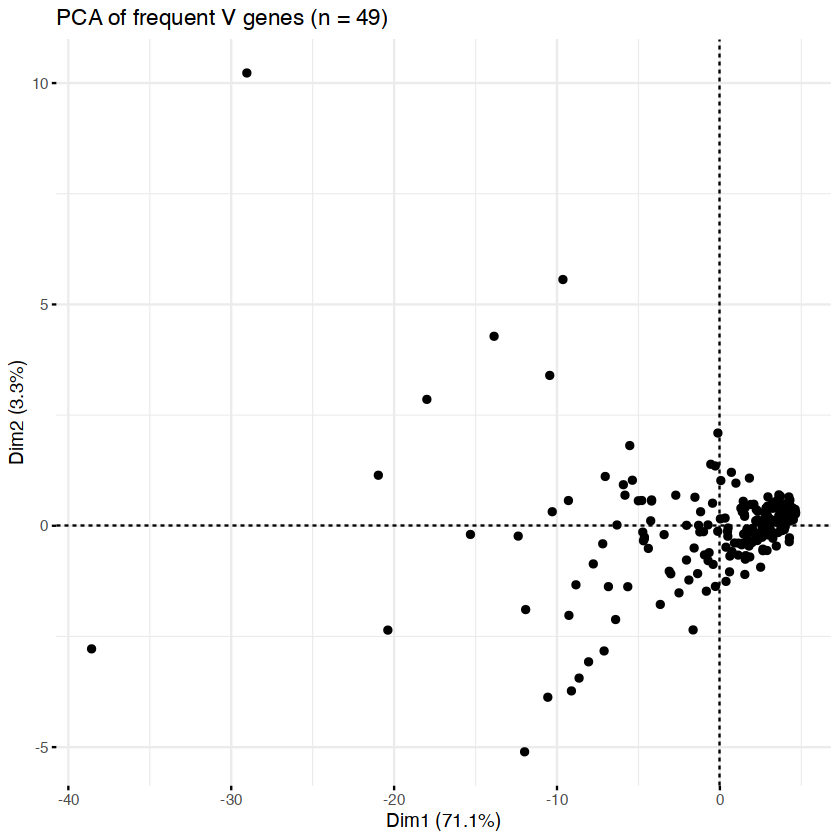

In [84]:
p0

In [85]:
readr::write_rds(mydf, paste0(datapath, "/capTCRseq/INT_PBMC_V_PCA_postqc.rds"))

# cfDNA

In [13]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [14]:
meta_div <- meta_div[ !is.na(meta_div$TRB), ]

In [15]:
meta_div <- meta_div[ meta_div$sampletype == "cfDNA",]

In [16]:
head(meta_div)

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,CHP_323_03,CHP_323,X03,0,786.24,1,HR ALL,0,0,NA,...,43.456,0.145,31.052,31.063,0.159,CHP_323-03_cfDNA,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_323-03_cfDNA.txt,cfDNA,CHP,1.6377198
2,CHP_323_05,CHP_323,X05,0,979.50,1,HR ALL,0,0,NA,...,8.686,0.093,6.804,6.812,0.134,CHP_323-05_cfDNA,remaining_batch_1_cfDNA_8April2021/mixcr/clones/CLONES_TRBCHP_323-05_cfDNA.txt,cfDNA,CHP,0.9380692
3,CHP_324_04,CHP_324,X04,0,0.00,12,T-ALL,0,0,NA,...,1.000,0.000,1.000,1.000,0.000,CHP_324-04_cfDNA,batch5_cfDNA_25Jun2020/mixcr/clones/CLONES_TRBCHP_324-04_cfDNA.txt,cfDNA,CHP,0.0000000
4,CHP_324_05,CHP_324,X05,0,0.00,12,T-ALL,0,0,NA,...,1.775,0.019,1.627,1.627,0.028,CHP_324-05_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_324-05_cfDNA.txt,cfDNA,CHP,0.2491984
5,CHP_326_05,CHP_326,X05,0,972.90,4,SR ALL,0,0,NA,...,16.475,0.087,14.065,14.075,0.099,CHP_326-05_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_326-05_cfDNA.txt,cfDNA,CHP,1.2165354
6,CHP_328_05,CHP_328,X05,0,91.16,7,SR ALL,0,0,NA,...,3.066,0.028,2.691,2.692,0.024,CHP_328-05_cfDNA,batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_328-05_cfDNA.txt,cfDNA,CHP,0.4864305


In [17]:
flelist <- file.path(paste0( h4hpath, "/NextSeq/", meta_div$file) )

In [18]:
head(flelist)

[1] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_323-03_cfDNA.txt"          
[2] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/remaining_batch_1_cfDNA_8April2021/mixcr/clones/CLONES_TRBCHP_323-05_cfDNA.txt"
[3] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batch5_cfDNA_25Jun2020/mixcr/clones/CLONES_TRBCHP_324-04_cfDNA.txt"            
[4] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_324-05_cfDNA.txt"           
[5] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_326-05_cfDNA.txt"           
[6] "/Users/anabbi/Desktop/H4H/INTERCEPT//NextSeq/batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_328-05_cfDNA.txt"

In [19]:
Vgene.fx <- function(fle){
    onefle <- read.table(fle, header = T, sep = "\t")
    basename <- gsub(".txt", "", basename(fle))
basename <- gsub("CLONES_TRB", "", basename)
onefle$basename <- basename
# Remove non-productive
onefle <- onefle[!grepl("_", onefle$aaSeqCDR3), ]
onefle <- onefle[!grepl("[*]", onefle$aaSeqCDR3), ]

 # if the file has no productive cdr3, message and exit
 if(nrow(onefle) == 0) { next }

# remove scores and take the first hit
onefle$TRBV <- gsub("[*]0.*", "", onefle$allVHitsWithScore)
onefle$TRBJ <- gsub("[*]0.*", "", onefle$allJHitsWithScore)
# remove super long cdr3s
onefle <- onefle[nchar(onefle$aaSeqCDR3) <= 25, ]

 #exit if the file has no productive cdr3
 if(nrow(onefle) == 0) { next }

onefle$cdr3_length <- nchar(onefle$aaSeqCDR3)
onefle_s <- onefle[, c("basename", "aaSeqCDR3", "cdr3_length", "TRBV", "TRBJ", "cloneCount", "cloneFraction")]

return(onefle_s)
}

In [21]:
myflelist <- lapply(flelist, Vgene.fx)

In [22]:
int_v_j_cdr3_l <- do.call("rbind", myflelist)

In [23]:
head(int_v_j_cdr3_l)

,basename,aaSeqCDR3,cdr3_length,TRBV,TRBJ,cloneCount,cloneFraction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
1,CHP_323-03_cfDNA,CASSQGTEGGYTF,13,TRBV4-3,TRBJ1-2,7047,0.06883248
2,CHP_323-03_cfDNA,CSARGRGKGADTQYF,15,TRBV20-1,TRBJ2-3,5287,0.05164145
3,CHP_323-03_cfDNA,CASRSDEKLFF,11,TRBV28,TRBJ1-4,4084,0.03989099
4,CHP_323-03_cfDNA,CAISDGQDTDTQYF,14,TRBV10-3,TRBJ2-3,3884,0.03793747
6,CHP_323-03_cfDNA,CASSPSNTEAFF,12,TRBV19,TRBJ1-1,3533,0.03450903
8,CHP_323-03_cfDNA,CASPGTGLYNQPQHF,15,TRBV30,TRBJ1-5,3079,0.03007453


In [24]:
readr::write_rds(int_v_j_cdr3_l, paste0(datapath, "capTCRseq/int_cfdna_v_j_cdr3_l.rds"))

In [25]:
int_v_j_cdr3_l <- readr::read_rds( paste0(datapath, "capTCRseq/int_cfdna_v_j_cdr3_l.rds"))

In [26]:
int_v <- int_v_j_cdr3_l %>% group_by(basename, TRBV) %>% summarize(Vcount = sum(cloneCount)) %>% ungroup()

`summarise()` has grouped output by 'basename'. You can override using the
`.groups` argument.


In [27]:
head(int_v)

basename,TRBV,Vcount
<chr>,<chr>,<int>
CHP_323-03_cfDNA,TRBV10-3,4967
CHP_323-03_cfDNA,TRBV11-1,24
CHP_323-03_cfDNA,TRBV11-2,1073
CHP_323-03_cfDNA,TRBV11-3,1212
CHP_323-03_cfDNA,TRBV12-3,55
CHP_323-03_cfDNA,TRBV12-4,1973


In [28]:
int_v_count <- tidyr::pivot_wider(int_v, names_from = "TRBV", values_from = "Vcount", values_fill = 0)

In [29]:
head(int_v_count)

basename,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV14,TRBV15,TRBV16,...,TRBV7-5,TRBV7-1,TRBV10-2,TRBV12-2,TRBV12-1,TRBV5-7,TRBV1,TRBV6-7,TRBV17,TRBV7-4
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CHP_323-03_cfDNA,4967,24,1073,1212,55,1973,259,345,1842,...,0,0,0,0,0,0,0,0,0,0
CHP_323-05_cfDNA,0,0,0,0,0,2061,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_324-04_cfDNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_324-05_cfDNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_326-05_cfDNA,709,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_328-05_cfDNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
int_v_count <- as.data.frame(int_v_count)
rownames(int_v_count) <- int_v_count$basename
int_v_count$basename <- NULL

In [31]:
head(int_v_count)

,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-3,TRBV12-4,TRBV14,TRBV15,TRBV16,TRBV18,...,TRBV7-5,TRBV7-1,TRBV10-2,TRBV12-2,TRBV12-1,TRBV5-7,TRBV1,TRBV6-7,TRBV17,TRBV7-4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CHP_323-03_cfDNA,4967,24,1073,1212,55,1973,259,345,1842,3106,...,0,0,0,0,0,0,0,0,0,0
CHP_323-05_cfDNA,0,0,0,0,0,2061,0,0,0,768,...,0,0,0,0,0,0,0,0,0,0
CHP_324-04_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_324-05_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_326-05_cfDNA,709,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_328-05_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
readr::write_rds(int_v_count, paste0(datapath, "capTCRseq/int_cfdna_v_count.rds"))

In [33]:
int_v <- int_v_j_cdr3_l %>% group_by(basename, TRBV) %>% summarize(Vfrac = sum(cloneFraction)) %>% ungroup()

`summarise()` has grouped output by 'basename'. You can override using the
`.groups` argument.


In [34]:
head(int_v)

basename,TRBV,Vfrac
<chr>,<chr>,<dbl>
CHP_323-03_cfDNA,TRBV10-3,0.0485158089
CHP_323-03_cfDNA,TRBV11-1,0.0002344231
CHP_323-03_cfDNA,TRBV11-2,0.0104806650
CHP_323-03_cfDNA,TRBV11-3,0.0118383653
CHP_323-03_cfDNA,TRBV12-3,0.0005372195
CHP_323-03_cfDNA,TRBV12-4,0.0192715303


In [35]:
int_v_fraction <- tidyr::pivot_wider(int_v, names_from = "TRBV", values_from = "Vfrac", values_fill = 0)

In [36]:
int_v_fraction <- as.data.frame(int_v_fraction)
rownames(int_v_fraction) <- int_v_fraction$basename
int_v_fraction$basename <- NULL

In [37]:
readr::write_rds(int_v_fraction, paste0(datapath, "capTCRseq/int_cfdna_v_fraction.rds"))

In [15]:
# should be done for all files
vfreq <- int_v_j_cdr3_l %>% group_by(TRBV) %>% tally() %>% arrange(desc(n)) %>% mutate(freq = n/sum(n)) %>% ungroup()

In [16]:
head(vfreq)

TRBV,n,freq
<chr>,<int>,<dbl>
TRBV20-1,280,0.07510730
TRBV19,245,0.06571888
TRBV5-1,211,0.05659871
TRBV28,173,0.04640558
TRBV6-5,161,0.04318670
TRBV27,155,0.04157725


In [17]:
tail(vfreq)

TRBV,n,freq
<chr>,<int>,<dbl>
TRBV17,1,0.0002682403
TRBV5-7,1,0.0002682403
TRBV6-7,1,0.0002682403
TRBV7-1,1,0.0002682403
TRBV7-4,1,0.0002682403
TRBV7-5,1,0.0002682403


In [18]:
readr::write_rds(vfreq, paste0(datapath, "capTCRseq/vfreq_int_cfdna.rds"))

In [19]:
summary(vfreq$freq)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0002682 0.0049625 0.0112661 0.0172414 0.0235381 0.0751073 

In [20]:
#low frequency V genes
lowfreq_v <- vfreq$TRBV[vfreq$freq < 0.001 ]

In [21]:
lowfreq_v

[1] "TRBV12-1" "TRBV12-2" "TRBV16"   "TRBV17"   "TRBV5-7"  "TRBV6-7"  "TRBV7-1" 
[8] "TRBV7-4"  "TRBV7-5"

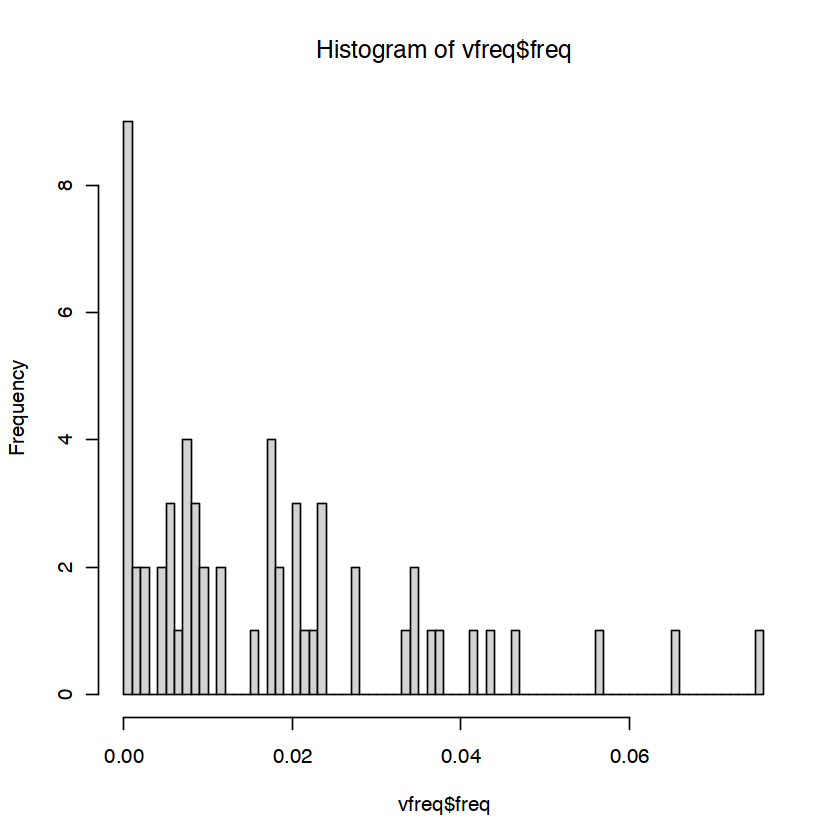

In [22]:
hist(vfreq$freq, breaks = 100)

In [23]:
vgene_mat <- as.data.frame.matrix(table(int_v_j_cdr3_l %>% select(basename, TRBV  )))

In [24]:
head(vgene_mat)

,TRBV1,TRBV10-1,TRBV10-2,TRBV10-3,TRBV11-1,TRBV11-2,TRBV11-3,TRBV12-1,TRBV12-2,TRBV12-3,...,TRBV7-1,TRBV7-2,TRBV7-3,TRBV7-4,TRBV7-5,TRBV7-6,TRBV7-7,TRBV7-8,TRBV7-9,TRBV9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
CHP_323-03_cfDNA,0,0,0,5,1,4,1,0,0,1,...,0,0,0,0,0,2,1,1,0,9
CHP_323-05_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
CHP_324-04_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_324-05_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHP_326-05_cfDNA,0,0,0,1,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,2,0
CHP_328-05_cfDNA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
readr::write_rds(vgene_mat, paste0(datapath, "capTCRseq/int_cfdna_vgene_matrix.rds"))

In [26]:
# remove lowfreq_v, hf = high freq
vgene_mat_hf <- vgene_mat[, !colnames(vgene_mat) %in% lowfreq_v ]

In [27]:
dim(vgene_mat_hf)

[1] 266  49

In [28]:
dim(vgene_mat)

[1] 266  58

In [29]:
cormat <- cor(vgene_mat_hf)

In [30]:
#vgene_mat_hf[,c("TRBV10-3", "TRBV7-9", "TRBV13")]

In [31]:
summary(as.vector(cormat) )

# generally high correlation

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.06903  0.15304  0.28437  0.28838  0.40388  1.00000 

PCA

In [32]:
mypca <- prcomp(vgene_mat_hf, scale = TRUE)

In [33]:
out <- mypca$x
mydf <- data.frame(out)

In [34]:
head(out)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
CHP_323-03_cfDNA,15.83866850,7.9531074,9.4381691,0.379325530,7.18074505,2.79783019,0.86589009,-2.86544186,-3.158583008,2.03969451,...,0.22108475,-0.23371871,0.53776231,-0.06676863,0.10654426,0.36256247,0.45532059,-0.4183013,-0.6505279,0.09932753
CHP_323-05_cfDNA,0.03694791,0.2037428,0.9895571,-2.176076742,1.07133588,1.43146515,1.35258930,-1.37627872,1.374466861,0.20393558,...,0.72594958,0.73361579,-0.06743142,-0.63041167,-0.13500831,0.53629075,-0.30678681,-0.9411188,0.5512794,0.18748726
CHP_324-04_cfDNA,-2.42588499,-0.2790740,0.1117550,-0.094609098,-0.05604981,0.08629582,0.03522337,-0.18379500,0.003041802,-0.02527073,...,0.11972688,-0.24618071,0.22611405,0.05030421,0.04167489,0.07560319,0.17417859,-0.4981331,-0.3808961,-0.13662565
CHP_324-05_cfDNA,-2.20171492,-0.2392266,0.1373460,-0.001147959,0.24775824,-0.06519060,-0.11251321,-0.10624861,0.365820190,0.15327150,...,-0.09990993,-0.30383943,-0.02730897,0.04507368,-0.01013837,0.11729085,0.03339129,-0.1548399,0.1263361,0.05863072
CHP_326-05_cfDNA,1.53369308,0.6800554,-0.7668898,0.786472419,-1.81313460,-0.95346835,1.14669547,0.08523654,0.030848305,1.03668470,...,-0.04481269,-0.04475912,-0.58740858,-0.19154568,-0.27191197,-0.17300584,-0.05734738,-0.4438526,0.1124433,-0.28540345
CHP_328-05_cfDNA,-1.73881538,-0.8087552,-0.8391630,1.129923007,0.06742512,0.36686128,0.05117531,-0.91311985,0.166227110,0.61812576,...,0.01893665,0.18739052,-0.35927512,0.32878444,0.27062479,0.50372462,0.50081465,0.3196915,0.2104239,-0.16289456


In [35]:
p0 <- fviz_pca_ind(mypca,geom = "point", pointshape = 16, pointsize = 2, alpha = 1,
                    ellipse.alpha = 0, invisible="quali", repel = TRUE,
                       title = "PCA of frequent V genes (n = 49)")

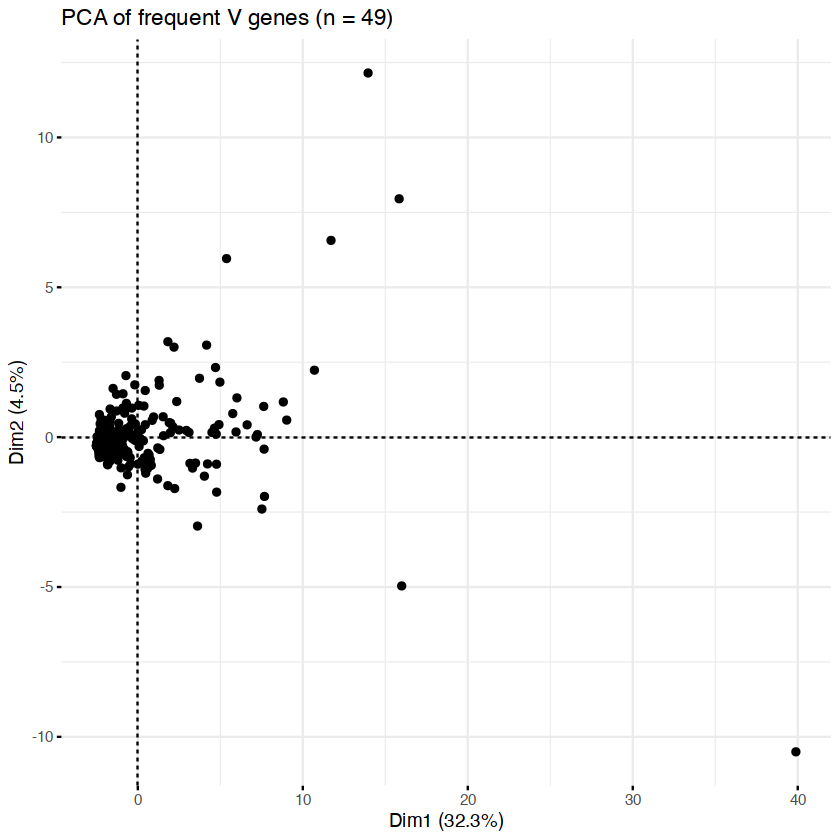

In [36]:
p0

In [37]:
readr::write_rds(mydf, paste0(datapath, "/capTCRseq/INT_cfDNA_V_PCA_postqc.rds"))